## RUL prediction using boosting

In this notebook, we will apply boosting to predict RUL of NASA's turbofan engine dataset FD001. To implement boosting, we will use [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) library.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(324)

In [2]:
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("XGBoost version: ", xgb.__version__)

Numpy version:  1.26.4
Pandas version:  2.0.3
XGBoost version:  2.1.3


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 1
* Shift: 1
* Data scaling: No (Tree based methods don't require data scaling)

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate. 

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly. 

In [3]:
CMAPSSData_path = "../../../__datasets/CMAPSSData/"

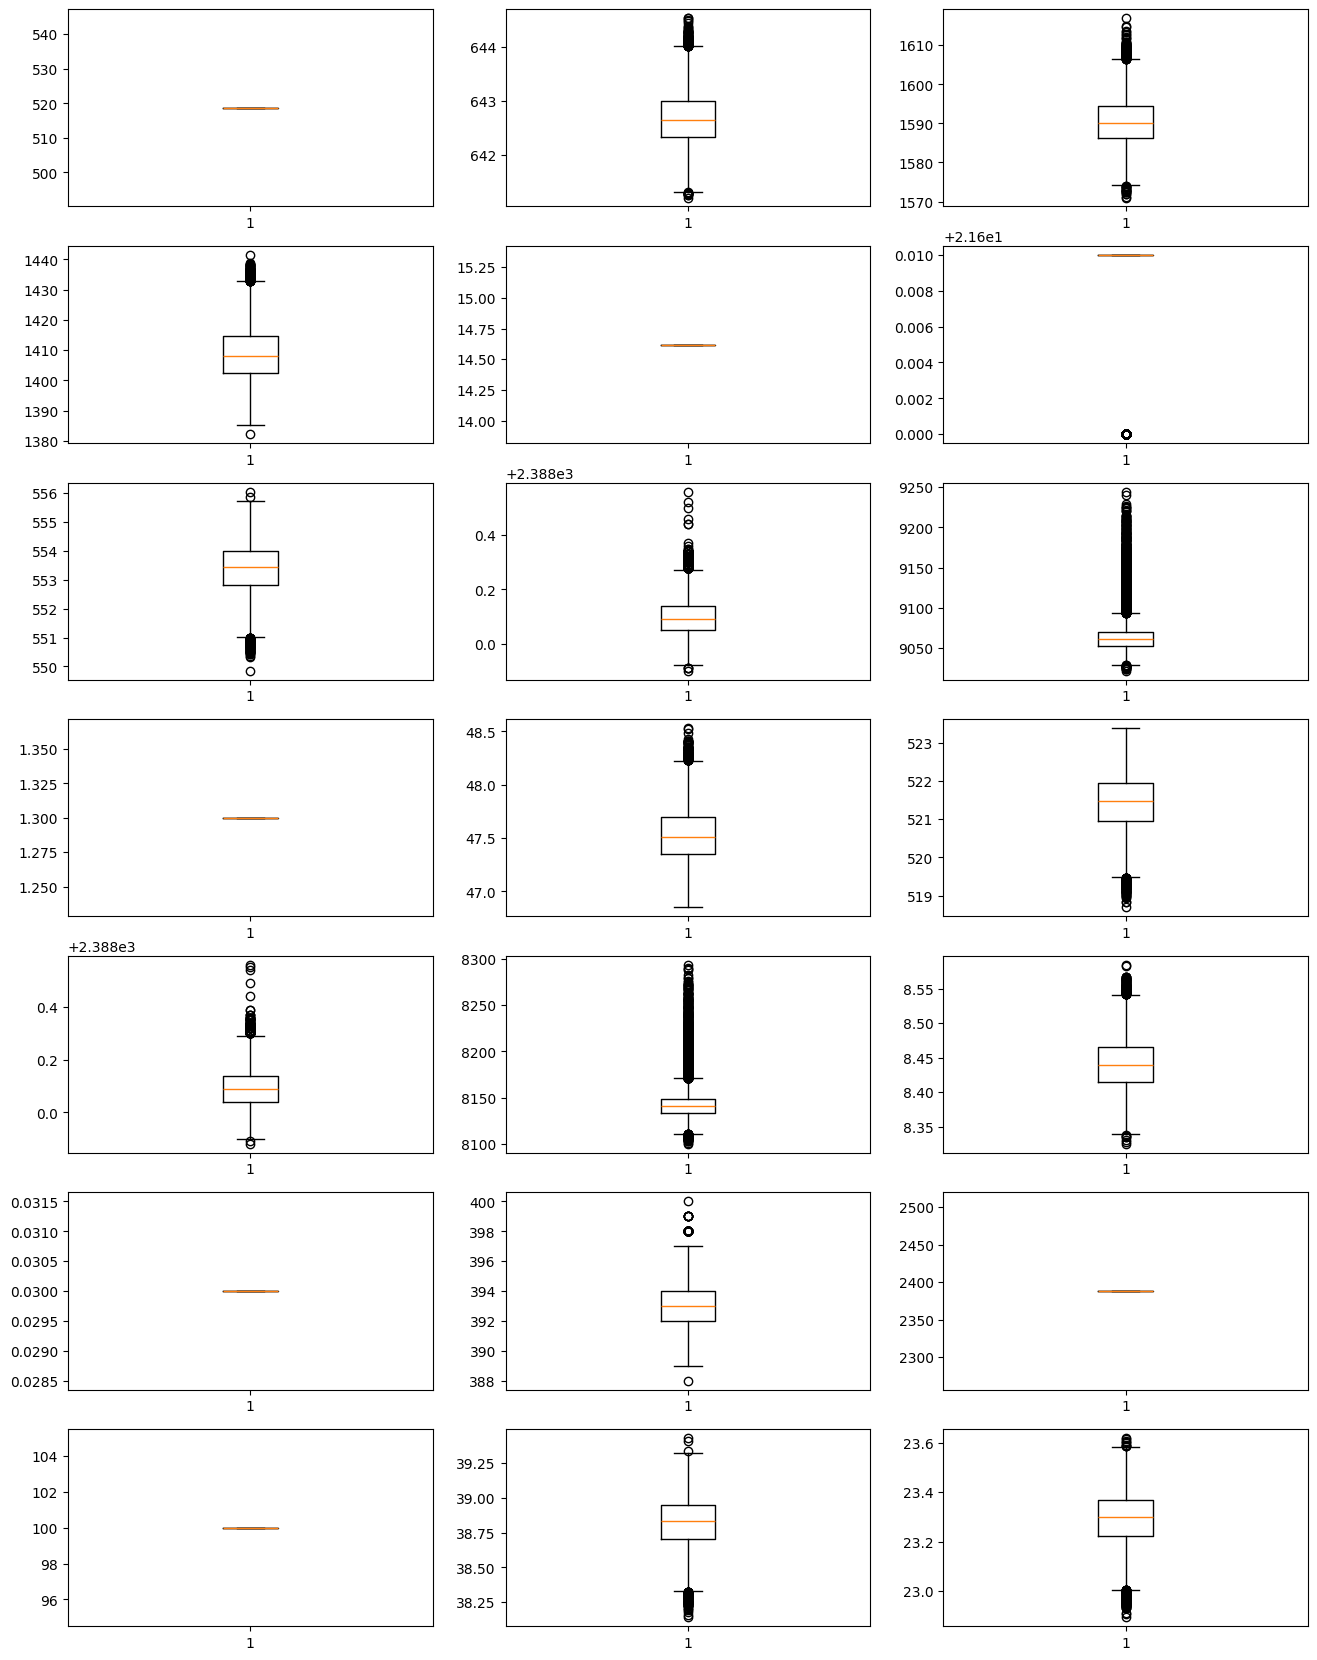

In [4]:
train_data = pd.read_csv(CMAPSSData_path+"/train_FD001.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

/tmp/ipykernel_1041931/2086600.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(temp_data, shade=True)  # 使用 KDE 繪製密度圖
/tmp/ipykernel_1041931/2086600.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(temp_data, shade=True)  # 使用 KDE 繪製密度圖
/tmp/ipykernel_1041931/2086600.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(temp_data, shade=True)  # 使用 KDE 繪製密度圖
/tmp/ipykernel_1041931/2086600.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(temp_data, shade=True)  # 使用 KDE 繪製密度圖
/tmp/ipykernel_1041931/2086600.py:15: FutureWarning:

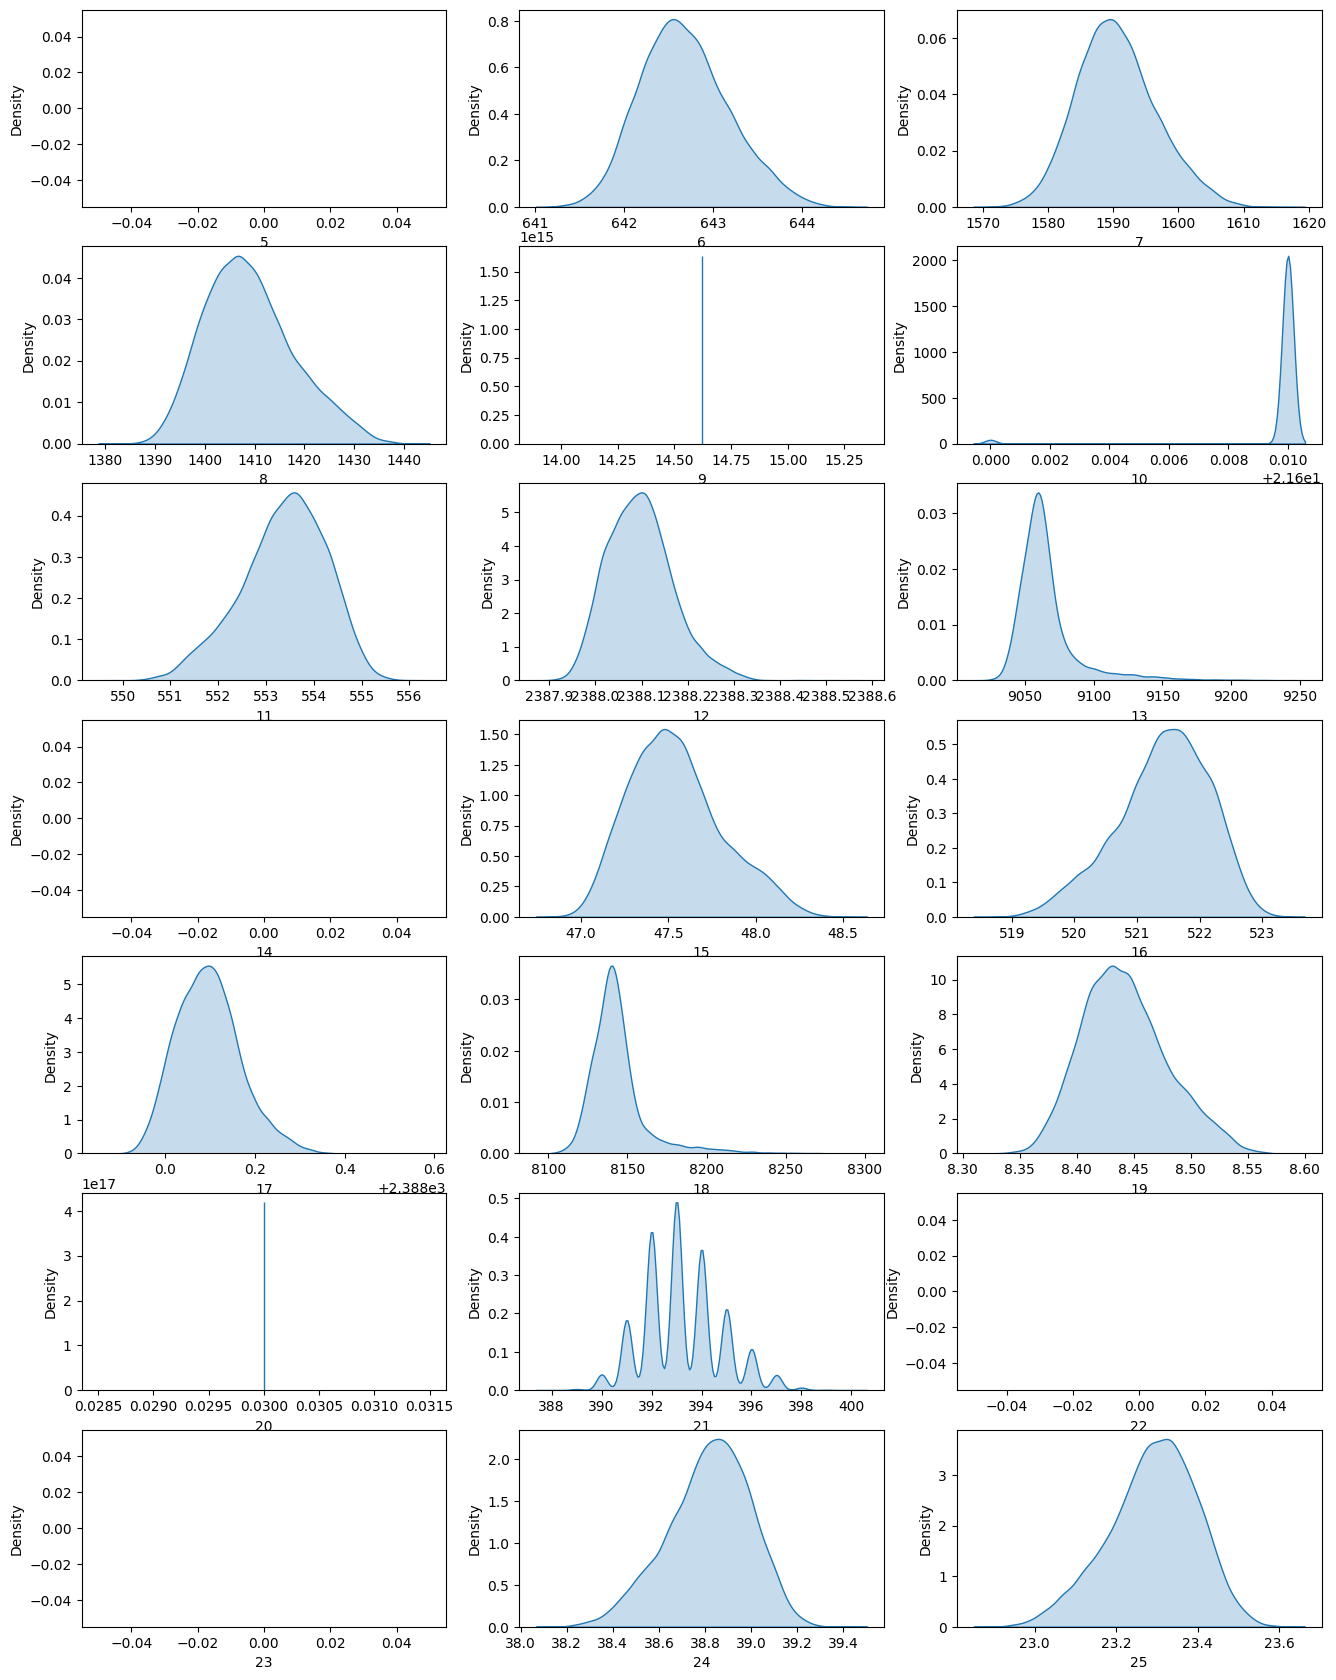

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假設 CMAPSSData_path 已經設定正確
train_data = pd.read_csv(CMAPSSData_path + "/train_FD001.txt", sep="\s+", header=None)

# 設置圖形大小
plt.figure(figsize=(16, 21))

# 繪製密度圖
for i in range(21):
    temp_data = train_data.iloc[:, i + 5]
    plt.subplot(7, 3, i + 1)
    sns.kdeplot(temp_data, shade=True)  # 使用 KDE 繪製密度圖

# 顯示圖形
plt.show()

In [6]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [7]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    # num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [8]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    # max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [9]:
test_data = pd.read_csv(CMAPSSData_path+"/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv(CMAPSSData_path+'/RUL_FD001.txt', sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine are taken. If set to a different number, that many windows from last are taken. 
# Final output is the average of output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

num_machines = np.min([len(train_data[0].unique()), len(test_data[0].unique())])

for i in np.arange(1, num_machines + 1):
    
    temp_train_data = train_data[train_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_test_data = test_data[test_data[0] == i].drop(columns=columns_to_be_dropped).values
    
    # Verify if data of given window length can be extracted from both training and test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    elif (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [10]:
processed_train_targets

array([ 50., 119., 125., ..., 125., 111., 120.])

In [11]:
processed_train_targets[:400]

array([ 50., 119., 125., 115.,  85.,  78.,   3.,  80.,  48., 125., 125.,
       100.,  28.,  56.,  35.,   2.,  40., 100.,  58.,  80.,  31.,  82.,
       100., 125.,   5.,  45., 110.,   3., 125., 125.,  10., 101., 121.,
       108.,  58.,  42.,  19.,  81., 107.,  28., 105., 125.,  79., 125.,
       125.,  89., 125., 125.,   8., 125., 125.,  29., 125.,  68., 116.,
       125.,  22., 125.,  61.,  20., 125.,  75.,  64., 117., 125.,  97.,
       124.,  71., 125., 125.,  55., 125., 104., 125., 125.,  87., 125.,
        22., 125.,  61., 125.,  71., 101., 125.,  19.,  92., 125., 125.,
        44., 106.,  33.,  85.,  75.,  69., 125.,  27.,  44., 125.,  50.,
        22.,  53., 125., 125.,  83., 125., 117.,   5.,  90.,  64., 125.,
       125., 125.,  21.,  80., 109.,   6., 107.,  11.,   1.,  64., 125.,
       125.,  75.,  39., 125., 125.,  33.,  79., 125.,  64.,  28.,  80.,
       125., 125.,  79., 125., 125.,  62., 125.,  71.,  22.,  32.,  58.,
        84., 123., 107., 125.,  22.,  97.,  98.,  2

In [12]:
processed_train_data.shape

(17731, 30, 14)

In [13]:
processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[1] * processed_train_data.shape[2])
processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[1] * processed_test_data.shape[2])
print("Processed train data shape: ", processed_train_data.shape)
print("Processed test data shape: ", processed_test_data.shape)

dtrain = xgb.DMatrix(processed_train_data, label = processed_train_targets)
dtest = xgb.DMatrix(processed_test_data)

Processed train data shape:  (17731, 420)
Processed test data shape:  (497, 420)


In [14]:
# processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[2])
# processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[2])
# print("Processed train data shape: ", processed_train_data.shape)
# print("Processed test data shape: ", processed_test_data.shape)

# dtrain = xgb.DMatrix(processed_train_data, label = processed_train_targets)
# dtest = xgb.DMatrix(processed_test_data)

In [15]:
num_rounds = 300
params = {"max_depth":3, "learning_rate":1, "objective":"reg:squarederror"}
bst = xgb.train(params, dtrain, num_boost_round = num_rounds, evals = [(dtrain, "Train")], verbose_eval = 50)

[0]	Train-rmse:23.31051
[50]	Train-rmse:14.47123
[100]	Train-rmse:12.28071
[150]	Train-rmse:10.75779
[200]	Train-rmse:9.54882
[250]	Train-rmse:8.52427
[299]	Train-rmse:7.71008


In [16]:
num_test_windows_list

[2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5]

In [17]:
np.unique(num_test_windows_list)

array([2, 5])

In [18]:
np.cumsum(num_test_windows_list)[:-1]

array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127,
       132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192,
       197, 202, 207, 212, 217, 222, 227, 232, 237, 242, 247, 252, 257,
       262, 267, 272, 277, 282, 287, 292, 297, 302, 307, 312, 317, 322,
       327, 332, 337, 342, 347, 352, 357, 362, 367, 372, 377, 382, 387,
       392, 397, 402, 407, 412, 417, 422, 427, 432, 437, 442, 447, 452,
       457, 462, 467, 472, 477, 482, 487, 492])

In [19]:
rul_pred = bst.predict(dtest)
rul_pred.shape, rul_pred

((497,),
 array([ 88.77268   , 105.82699   , 107.33872   ,  94.0167    ,
        145.55347   , 102.49269   , 110.07303   ,  82.677864  ,
         67.67646   ,  87.2071    ,  44.697502  ,  58.015987  ,
        112.69956   , 111.50763   ,  98.817     ,  95.8212    ,
        113.00309   ,  79.15193   , 102.793205  , 108.7437    ,
         93.1822    , 105.48654   , 111.67422   , 102.33599   ,
         89.969826  ,  71.02833   ,  66.39878   , 112.970146  ,
        100.470795  ,  74.87145   ,  70.248055  ,  87.972855  ,
        126.8941    ,  87.79318   , 111.735825  , 111.91292   ,
         91.098366  , 116.77445   , 102.67839   ,  76.979805  ,
        139.92088   , 124.37198   , 100.94878   ,  84.522865  ,
         96.34354   , 101.34711   ,  84.336075  ,  85.53888   ,
         92.63396   ,  90.59323   , 126.11344   ,  61.605564  ,
         97.54732   , 124.822044  , 104.19239   ,  98.776634  ,
         99.61679   ,  63.99352   ,  71.35382   , 105.36908   ,
         95.46847   ,  71.87272

In [20]:
# First split predictions according to number of windows of each engine
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  16.248184359748148


With somewhat arbitrary choice of hyperparameters, we obtained an RMSE value of 19.78. But can we do better? To find out better values of hyperparameters, we can do a principled hyperparameter tuning. There are different ways to do hyperparameter search. Here, we will use simple grid search. 

In grid search, we first define a grid of parameters. Then for each set of parameters, we will fit a 10 xgboost models (as it is 10 fold cross validation). Finally we will average the result of all folds for a particular parameter choice. The parameter choice that gives best score for cross validation is chosen as the best hyperparameter.

Grid search of hyperparameters (with cross validation) is computationally intensive. It might take a long time on a personal computer. If that is the case, readers are advised to comment the next cell and directly use the best hyperparameter values as done in subsequent cells.

In [21]:
param_grid = [(max_depth, eta) for max_depth in np.arange(2,6) for eta in np.array([0.01, 0.1, 0.3, 0.5, 1])]

min_rmse = np.inf
best_params = None
params = dict()
params["objective"] = "reg:squarederror"
for max_depth, eta in param_grid:
    print("max_depth: {}, eta: {}".format(max_depth, eta))
    
    params["max_depth"] = max_depth
    params["eta"] = eta
    
    cv_res = xgb.cv(params, dtrain, num_boost_round= num_rounds, early_stopping_rounds= 10, nfold = 10, seed = 89)
    
    best_rmse_val = cv_res["test-rmse-mean"].min()
    best_num_rounds = cv_res["test-rmse-mean"].argmin() + 1
    
    print("RMSE: {} in {} rounds".format(best_rmse_val, best_num_rounds))
    print()
    
    if best_rmse_val < min_rmse:
        min_rmse = best_rmse_val
        best_params = (max_depth, eta, best_num_rounds)
        
print("Best parameters are: Max_depth= {}, eta= {}, num_rounds = {}. Corresponding RMSE: {}".format(best_params[0],
                                                                                                    best_params[1],
                                                                                                    best_params[2],
                                                                                                    min_rmse))

max_depth: 2, eta: 0.01
RMSE: 19.89223597509532 in 300 rounds

max_depth: 2, eta: 0.1
RMSE: 15.709424398670341 in 300 rounds

max_depth: 2, eta: 0.3
RMSE: 15.092164910065126 in 298 rounds

max_depth: 2, eta: 0.5
RMSE: 15.441744251291505 in 300 rounds

max_depth: 2, eta: 1.0
RMSE: 17.36775296102794 in 154 rounds

max_depth: 3, eta: 0.01
RMSE: 18.750499417309705 in 300 rounds

max_depth: 3, eta: 0.1
RMSE: 14.938356527558213 in 300 rounds

max_depth: 3, eta: 0.3
RMSE: 15.175043609556113 in 226 rounds

max_depth: 3, eta: 0.5
RMSE: 16.031079244311297 in 136 rounds

max_depth: 3, eta: 1.0
RMSE: 18.700496259384884 in 52 rounds

max_depth: 4, eta: 0.01
RMSE: 18.092021988304737 in 300 rounds

max_depth: 4, eta: 0.1
RMSE: 14.524756180787605 in 300 rounds

max_depth: 4, eta: 0.3
RMSE: 15.270164602316479 in 187 rounds

max_depth: 4, eta: 0.5
RMSE: 16.498382619930446 in 66 rounds

max_depth: 4, eta: 1.0
RMSE: 19.76796912796779 in 18 rounds

max_depth: 5, eta: 0.01
RMSE: 17.547397999289476 in 300 ro

We will use the best parameters to train the final regressor. The `num_boost_round` value obtained above is the best value for cross validation. We can take a value that is different from the above number but not very far from it. 

In [22]:
params_tuned = {"max_depth":5, "eta":0.1, "objective":"reg:squarederror"}
bst_tuned = xgb.train(params_tuned, dtrain, num_boost_round= 100)

rul_pred_tuned = bst_tuned.predict(dtest)

preds_for_each_engine_tuned = np.split(rul_pred_tuned, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_tuned = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                                   for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_tuned,
                                                                                num_test_windows_list)]
RMSE_tuned = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_tuned))
print("RMSE after hyperparameter tuning: ", RMSE_tuned)

RMSE after hyperparameter tuning:  15.718904291320925


Note that while prediction, we are predicting RUL values for last 5 examples of every engine. Then we take mean of all 5 predictions for each engine and calculate final RMSE.

If instead we wish to take only the last example of every engine to make predictions and calculate RUL, we can do so by taking the last prediction of every engine as calculated before and calculate RMSE as follows.

In [23]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
indices_of_last_examples

array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
       131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191,
       196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256,
       261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321,
       326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386,
       391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451,
       456, 461, 466, 471, 476, 481, 486, 491, 496])

In [24]:
preds_for_last_example = np.concatenate(preds_for_each_engine_tuned)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.673160942102303


If you are not convinced by above calculations, for the sake of clarity, we will do the same thing in a more conventional way. First, we will extract last examples from each engine. Then we will make predictions using that data and compute new RMSE value. Finally, we will compare predicted rul of conventional method to that obtained before.

We will do this only for this example as a demonstration. For other notebooks, we will just use results as obtained above.

In [25]:
test_data = pd.read_csv(CMAPSSData_path+"/test_FD001.txt", sep = "\s+", header = None)

window_length = 1
shift = 1

num_test_windows = 1    
processed_test_data_new = []
num_test_windows_list_new = []

for i in np.arange(1, num_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns=columns_to_be_dropped).values
    
    # Verify if data of given window length can be extracted from both training and test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data_new.append(test_data_for_an_engine)
    num_test_windows_list_new.append(num_windows)

processed_test_data_new = np.concatenate(processed_test_data_new)


print("Processed test data shape: ", processed_test_data_new.shape)
print("True RUL shape: ", true_rul.shape)

Processed test data shape:  (100, 1, 14)
True RUL shape:  (100,)


In [26]:
processed_test_data_new = processed_test_data_new.reshape(-1, processed_test_data_new.shape[2])
print("New processed test data shape: ", processed_test_data_new.shape)

New processed test data shape:  (100, 14)


Now we will predict using new processed test data.

In [27]:
dtest_new = xgb.DMatrix(processed_test_data_new)
rul_pred_new = bst_tuned.predict(dtest_new)

RMSE_new = np.sqrt(mean_squared_error(true_rul, rul_pred_new))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  87.40050666451953


Now compare `rul_pred_new` with previous prediction result.

In [28]:
rul_pred_new

array([ -6.3007593 ,   1.9230589 ,   1.376841  ,   2.7910752 ,
         3.3061814 ,   0.43035123,  -7.0412183 ,   5.7557707 ,
         0.81843364,  -1.6086286 ,   3.412768  ,  -3.9274974 ,
         2.5128846 ,  -0.91852367,  -2.9654682 ,  -3.7904935 ,
        -1.916171  ,   1.9184335 ,  -3.7451863 ,   3.6990764 ,
        -2.4453962 ,  -3.1279857 ,  -8.0786295 ,   1.9464544 ,
        -1.3447055 ,  -5.1167307 ,  -0.30301532,   1.7872342 ,
         1.2436227 ,   4.9581513 ,   3.6400554 ,  -3.6275501 ,
         2.9825368 ,   3.76731   ,   3.6400554 ,   3.76731   ,
         3.76731   ,   3.7003849 ,  -8.752283  ,   3.2333493 ,
         6.8106685 ,   3.76731   ,   4.0616293 ,  -0.44653407,
         1.6503929 ,   2.8784394 ,   4.7353826 ,  -1.5312012 ,
         3.76731   ,  -2.899171  ,   3.409226  ,   3.1371884 ,
         2.316905  ,  -7.779856  ,  -5.6603785 ,   3.76731   ,
         1.3485502 ,   4.0986943 ,  -6.780593  ,  -0.1461778 ,
         3.2333493 ,   0.23705623,   4.0616293 ,   3.76

In [29]:
preds_for_last_example

array([116.99426  , 115.00812  ,  61.74694  ,  97.06667  , 113.09655  ,
       104.30502  , 103.61222  ,  97.06781  , 112.81281  ,  87.56121  ,
        91.559715 ,  99.12905  ,  88.28762  , 110.5775   , 116.5723   ,
       111.46608  ,  58.301914 ,  42.802296 ,  99.347    ,  14.797553 ,
        69.78285  , 117.337395 , 118.44578  ,  19.116344 , 115.190735 ,
       104.6815   ,  98.3417   , 104.85042  , 101.35861  , 112.63089  ,
        17.367409 ,  47.129147 , 105.150505 ,   1.4682472,   8.745419 ,
        20.356573 ,  47.646626 ,  48.00993  , 118.98266  ,  30.989887 ,
        22.01987  ,  12.6365   ,  74.06899  ,  92.79491  ,  81.91792  ,
        39.59238  , 109.733536 , 102.12044  ,  16.715433 , 101.5376   ,
       108.387955 ,  28.319847 ,  34.166245 , 120.98058  , 112.061    ,
        13.232486 , 101.45796  ,  50.114178 , 106.745995 , 105.78842  ,
        33.083344 ,  45.554283 ,  97.72633  ,  35.982006 , 120.51546  ,
        15.395039 , 105.42007  ,  13.274628 , 101.14876  , 115.3

As we can see, both predictions are identical. So we need not do conventional calculations again. 

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [30]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [31]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  393.3025053495539


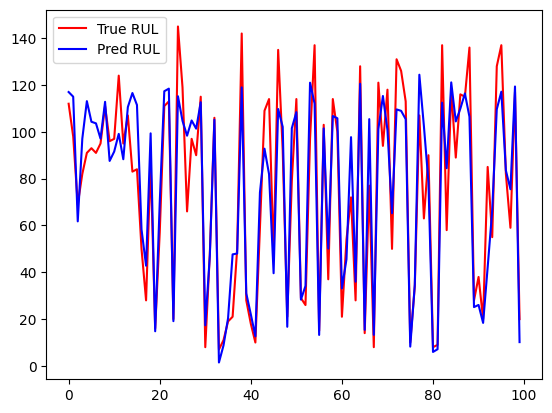

In [32]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

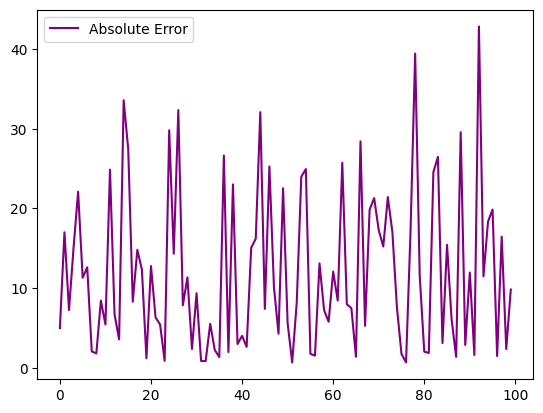

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 計算絕對誤差
absolute_error = np.abs(true_rul - preds_for_last_example)

# 繪製絕對誤差
plt.plot(absolute_error, label="Absolute Error", color="purple")
plt.legend()
plt.show()

In [34]:
absolute_error.mean()

12.087899987697602

We can also plot variable importance score.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

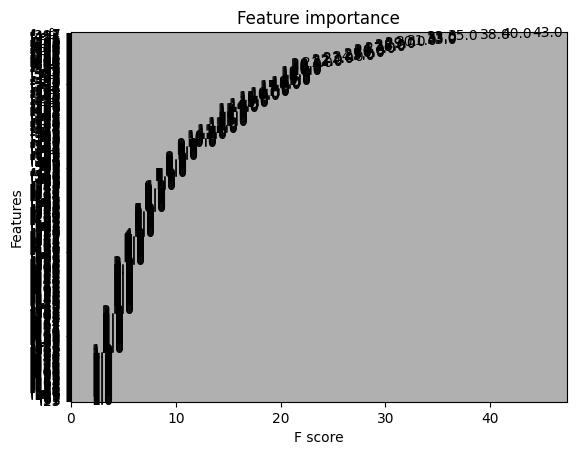

In [ ]:
# xgb.plot_importance(bst_tuned)

As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open). 